In [1]:
import numpy as np
import pandas as pd
from pandas.io import gbq

import re

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import cluster, metrics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", palette="Set3")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
taxonomy_data_playlists = gbq.read_gbq('SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.amplify_taxonomy_playlists`',
    project_id='umg-comm-tech-dev', dialect='standard')

In [6]:
taxonomy_data_tracks = gbq.read_gbq('SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.amplify_taxonomy_tracks`',
    project_id='umg-comm-tech-dev', dialect='standard')

In [7]:
print(taxonomy_data_playlists.shape)
print(taxonomy_data_tracks.shape)

(403, 8)
(4011, 10)


In [8]:
taxonomy_data_playlists['lvl_3']=np.nan
taxonomy_data_playlists['lvl_4']=np.nan

taxonomy_data_playlists['source']='playlists'
taxonomy_data_tracks['source']='tracks'

taxonomy_data = pd.concat([taxonomy_data_playlists,taxonomy_data_tracks], ignore_index=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [9]:
taxonomy_data.head(10)

,description,lvl_0,lvl_1,lvl_2,lvl_3,lvl_4,name,path,source,taggable,taxonomynodeid
0,Sung Christian music with roots in traditional...,Genre,Gospel,None,NaN,NaN,Classic Gospel,Genre/Gospel/Classic Gospel,playlists,true,9e70e1a7-3e64-4704-9175-f5069732a97a
1,Characterized by a loose narrative lyrical sty...,Genre,None,None,NaN,NaN,Blues,Genre/Blues,playlists,true,e6576040-ba5a-4f51-b547-3d1ec7005afd
2,Traditional Western art music. Though wide-ran...,Genre,None,None,NaN,NaN,Classical,Genre/Classical,playlists,true,9d557d09-c923-410c-b2c9-3239d073d703
3,Characterized by the use of guitar and twangy ...,Genre,None,None,NaN,NaN,Country,Genre/Country,playlists,true,6dc2a882-8bf6-423e-a9e8-07615ac91154
4,Created primarily by electronic instruments an...,Genre,None,None,NaN,NaN,Electronic,Genre/Electronic,playlists,true,195e1e65-82e9-4a49-96de-fca22301027e
5,Refers both to the traditional folk music of t...,Genre,None,None,NaN,NaN,Folk,Genre/Folk,playlists,true,da8a990f-9398-483d-8284-80d01c4ef634
6,Sung Christian music with roots in traditional...,Genre,None,None,NaN,NaN,Gospel,Genre/Gospel,playlists,true,f814d27a-2e75-48a7-b2aa-731e6e0ac95a
7,Typically features rapped vocals (emphasis on ...,Genre,None,None,NaN,NaN,Hip-Hop,Genre/Hip-Hop,playlists,true,c9827769-5b34-4403-8921-eb103f322fbf
8,Wide-ranging genre characterized by the use of...,Genre,None,None,NaN,NaN,Jazz,Genre/Jazz,playlists,true,a6e9ef88-0f2e-4624-9275-34fdcfaea7b2
9,Umbrella genre that encompasses most music fro...,Genre,None,None,NaN,NaN,Latin,Genre/Latin,playlists,true,e31d4b6d-eadb-4ddd-a97f-37137642f571


In [10]:
taxonomy_data['playlist_taggable']=[1 if (x=='true')&(y=='playlists') else 0 for x,y in zip(taxonomy_data.taggable,taxonomy_data.source)]

In [11]:
taxonomy_data['track_taggable']=[1 if (x=='true')&(y=='tracks') else 0 for x,y in zip(taxonomy_data.taggable,taxonomy_data.source)]

In [12]:
by_id = taxonomy_data.sort_values(by='source').groupby(by='taxonomynodeid')

In [13]:
df_id = pd.DataFrame(by_id.playlist_taggable.max())

In [14]:
df_id['track_taggable'] = by_id.track_taggable.max()
df_id['name'] = by_id.name.max()

In [15]:
df_id['playlist_path'] = by_id.path.first()
df_id['track_path'] = by_id.path.last()

In [16]:
df_id = df_id.reset_index()
df_id.head()

,taxonomynodeid,playlist_taggable,track_taggable,name,playlist_path,track_path
0,000653e1-ad81-48bb-bd62-991278ef9694,0,1,Clavinet,Performance/Instrument/Keyboard/Electric Piano...,Performance/Instrument/Keyboard/Electric Piano...
1,000cc4ca-6de4-4d7e-82a8-95093105e421,1,1,Mariachi Band,Ensemble/Ensemble Configuration/Mariachi Band,Performance/Ensemble/Ensemble Configuration/Ma...
2,0010a1e7-51a9-4a74-8c94-09c1166e3abb,0,1,Atumpan,Performance/Instrument/Percussion/Unpitched/At...,Performance/Instrument/Percussion/Unpitched/At...
3,001de9c6-3bd6-4374-861b-f53f7c26b7db,0,1,Spring,Lyrics/Lyric Theme/Time/Season/Spring,Lyrics/Lyric Theme/Time/Season/Spring
4,00343eb3-9efd-4dcb-89b5-ce2cf9d43dbd,0,1,Denver,Lyrics/Lyric Theme/Place/Geographic Location/C...,Lyrics/Lyric Theme/Place/Geographic Location/C...


In [17]:
df_id[(df_id.track_path.str.contains("Artist/Ensemble"))&(df_id.playlist_taggable==1)].sort_values(by='playlist_path').to_clipboard()

In [18]:
df_id[(df_id.track_path.str.contains("Anatomy/Arrangement"))&(df_id.playlist_taggable==1)].sort_values(by='playlist_path')

,taxonomynodeid,playlist_taggable,track_taggable,name,playlist_path,track_path
831,343f284f-06d7-47b7-8b9b-076c4511e998,1,1,A Cappella,Arrangement/A Cappella,Anatomy/Arrangement/A Cappella
2743,ad19f314-c5c6-4de8-bba5-4456577b4300,1,1,Instrumental,Arrangement/Instrumental,Anatomy/Arrangement/Instrumental
3514,df112352-99b1-4cda-b46b-6b68d97ed796,1,1,Voice & Music,Arrangement/Voice & Music,Anatomy/Arrangement/Voice & Music


In [19]:
df_playlists = df_id[df_id.playlist_taggable==1]
df_tracks = df_id[df_id.track_taggable==1]
df_both = df_tracks[df_tracks.taxonomynodeid.isin(df_playlists.taxonomynodeid)]

In [20]:
print("Playlists tags: ", df_playlists.shape[0])
print("Tracks tags: ", df_tracks.shape[0])
print("Both tags: ", df_both.shape[0])

Playlists tags:  387
Tracks tags:  3918
Both tags:  360


In [21]:
df_playlists[df_playlists.taxonomynodeid.isin(df_tracks.taxonomynodeid)==False]

,taxonomynodeid,playlist_taggable,track_taggable,name,playlist_path,track_path
85,05656b8a-45da-4f5a-ad59-ed9f155bdc95,1,0,One Hit Wonder,Playlist/Theme/One Hit Wonder,Playlist/Theme/One Hit Wonder
118,07490913-8d97-4494-91e2-9624e9bb278b,1,0,Band,Artist/Ensemble/Band,Artist/Ensemble/Band
155,096abec2-2f9a-46d5-b395-9222a1856a2c,1,0,New Music/Frontline,Contents/New Music/Frontline,Contents/New Music/Frontline
169,0a0bdffd-1883-4e04-ade1-13d20e47822d,1,0,Greatest Hits/Best Of...,Popularity/Greatest Hits/Best Of...,Popularity/Greatest Hits/Best Of...
219,0cf05e41-8c8a-4beb-8277-7e3695f443ad,1,0,Awards Show,Event/Awards Show,Event/Awards Show
689,2a9ab7f1-94ca-495b-88e6-71e6367fc4d4,1,0,Solo,Artist/Ensemble/Solo,Artist/Ensemble/Solo
700,2b48a846-8165-4c56-b79a-afeee8a480fe,1,0,Acoustic Pop,Genre/Pop/Acoustic Pop,Genre/Pop/Acoustic Pop
872,36bbd52c-17b8-4cd1-9877-7d636853cf6e,1,0,Texas Country,Genre/Country/Modern Country/Texas Country,Genre/Country/Modern Country/Texas Country
932,3a9cefd0-7b93-4b86-aac4-835755112bfa,1,0,Timeless Classics,Playlist/Theme/Timeless Classics,Playlist/Theme/Timeless Classics
1176,4a216215-f760-48e2-9694-5dfb93920ca9,1,0,Dynamic,Intensity/Dynamic,Intensity/Dynamic


In [22]:
tags = gbq.read_gbq('SELECT * FROM `umg-comm-tech-dev.adhoc.amplify_analysis`',
    project_id='umg-comm-tech-dev', dialect='standard')
tags.head()

,tagged_entity_type,playlist_id,isrc,path,value,taxonomy_node_id,source,confidence
0,StreamingPlaylist,3fGdxCiXu9ByRZUA7QeqOD,,Genre/R&B,Funk,8a7b0f84-823d-4905-8471-574de982d71c,Manual,1.0
1,StreamingPlaylist,6IJNg37ejhBbAwfNqe8yme,,Genre/Rock,Punk,a80ba8b4-c477-491b-b1e8-818c7b82efd6,Manual,1.0
2,StreamingPlaylist,0XKz5dOHLZQSHWgkn2jL7Q,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0
3,StreamingPlaylist,0ejM8M3JPmlMK7n5cbg8zl,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0
4,StreamingPlaylist,7iMyUkmPe7epyb8J1mqT9y,,Application/Playlist/Time/Holiday,Christmas,c3de98f1-f82d-4c9f-9d93-e4c1f84a43db,Manual,1.0


In [23]:
playlist_tags = tags[tags.tagged_entity_type=='StreamingPlaylist']
playlist_tags_nonanpath = playlist_tags[playlist_tags.path.isnull()==False]

In [24]:
playlist_tags_df = playlist_tags_nonanpath[playlist_tags_nonanpath.playlist_id!='Umg.Amplify.Core.EntityIdentifier']

In [30]:
playlist_tags_df.shape

(7603, 8)

In [29]:
#Get new tags
tags_ensemble = gbq.read_gbq("SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.new_tags_artist_ensemble`", 
                             dialect='standard', project_id='umg-comm-tech-dev')
tags_contents = gbq.read_gbq("SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.new_tags_contents`",
                            dialect='standard', project_id='umg-comm-tech-dev')
tags_popularity = gbq.read_gbq("SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.new_tags_popularity`",
                              dialect='standard', project_id='umg-comm-tech-dev')

In [31]:
all_tags = pd.concat([playlist_tags_df, tags_ensemble], ignore_index=True)
all_tags = pd.concat([all_tags, tags_contents], ignore_index=True)
all_tags = pd.concat([all_tags, tags_popularity], ignore_index=True)

all_tags.shape

(12568, 8)

In [35]:
all_tags.head()

,tagged_entity_type,playlist_id,isrc,path,value,taxonomy_node_id,source,confidence
0,StreamingPlaylist,3fGdxCiXu9ByRZUA7QeqOD,,Genre/R&B,Funk,8a7b0f84-823d-4905-8471-574de982d71c,Manual,1.0
1,StreamingPlaylist,6IJNg37ejhBbAwfNqe8yme,,Genre/Rock,Punk,a80ba8b4-c477-491b-b1e8-818c7b82efd6,Manual,1.0
2,StreamingPlaylist,0XKz5dOHLZQSHWgkn2jL7Q,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0
3,StreamingPlaylist,0ejM8M3JPmlMK7n5cbg8zl,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0
4,StreamingPlaylist,7iMyUkmPe7epyb8J1mqT9y,,Application/Playlist/Time/Holiday,Christmas,c3de98f1-f82d-4c9f-9d93-e4c1f84a43db,Manual,1.0


In [36]:
all_tags['isrc']=''

In [37]:
playlist_tags_final = all_tags.dropna(axis=0)
playlist_tags_final.shape

(12546, 8)

In [38]:
playlist_tags_final['path_and_value'] = ['/'.join([str(x),str(y)]) for x,y in zip(playlist_tags_final.path, playlist_tags_final.value)]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
playlist_tags_final.head()

,tagged_entity_type,playlist_id,isrc,path,value,taxonomy_node_id,source,confidence,path_and_value
0,StreamingPlaylist,3fGdxCiXu9ByRZUA7QeqOD,,Genre/R&B,Funk,8a7b0f84-823d-4905-8471-574de982d71c,Manual,1.0,Genre/R&B/Funk
1,StreamingPlaylist,6IJNg37ejhBbAwfNqe8yme,,Genre/Rock,Punk,a80ba8b4-c477-491b-b1e8-818c7b82efd6,Manual,1.0,Genre/Rock/Punk
2,StreamingPlaylist,0XKz5dOHLZQSHWgkn2jL7Q,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0,Application/Playlist/Activity/Sleeping
3,StreamingPlaylist,0ejM8M3JPmlMK7n5cbg8zl,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0,Application/Playlist/Activity/Sleeping
4,StreamingPlaylist,7iMyUkmPe7epyb8J1mqT9y,,Application/Playlist/Time/Holiday,Christmas,c3de98f1-f82d-4c9f-9d93-e4c1f84a43db,Manual,1.0,Application/Playlist/Time/Holiday/Christmas


In [40]:
playlist_tags_final.shape

(12546, 9)

In [41]:
df_cols = ['playlist_id']+list(df_playlists.playlist_path.unique())
df = pd.DataFrame(columns=df_cols)
df['playlist_id'] = playlist_tags_final['playlist_id']
df.head()

,playlist_id,Ensemble/Ensemble Configuration/Mariachi Band,Intensity/Low/Low Intensity,Playlist/Time/Month/May,Playlist/Theme/Scary,Playlist/Theme/One Hit Wonder,Artist/Ensemble/Band,Playlist/Time/Century/1400s,Emotion/Attitude/Majestic,Genre/Traditional/Irish,...,Instrument/Wind,Emotion/Negative/Fearful,Emotion/Positive/Blissful,Playlist/Mood/Feeling Good,Playlist/Time/Holiday/New Year,Genre/Pop,Playlist/Activity/Working,Genre/R&B/Soul,Genre/Rock,Playlist/Location/Galaxy
0,3fGdxCiXu9ByRZUA7QeqOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6IJNg37ejhBbAwfNqe8yme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0XKz5dOHLZQSHWgkn2jL7Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0ejM8M3JPmlMK7n5cbg8zl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7iMyUkmPe7epyb8J1mqT9y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
for col_id,col in zip(df_playlists.taxonomynodeid,df_playlists.playlist_path):
    print("Processing tag: ", col)
    ids = playlist_tags_final[playlist_tags_final.taxonomy_node_id==col_id].playlist_id.unique()
    
    df[col] = [1 if x in ids else 0 for x in df.playlist_id]

Processing tag:  Ensemble/Ensemble Configuration/Mariachi Band
Processing tag:  Intensity/Low/Low Intensity
Processing tag:  Playlist/Time/Month/May
Processing tag:  Playlist/Theme/Scary
Processing tag:  Playlist/Theme/One Hit Wonder
Processing tag:  Artist/Ensemble/Band
Processing tag:  Playlist/Time/Century/1400s
Processing tag:  Emotion/Attitude/Majestic
Processing tag:  Genre/Traditional/Irish
Processing tag:  Contents/New Music/Frontline
Processing tag:  Popularity/Greatest Hits/Best Of...
Processing tag:  Playlist/Location/Moon
Processing tag:  Intensity/Medium/Medium Intensity
Processing tag:  Playlist/Mood/Confident
Processing tag:  Event/Awards Show
Processing tag:  Playlist/Time/Time Of Day/Morning
Processing tag:  Playlist/Theme/Sun
Processing tag:  Playlist/Time/Day Of Week
Processing tag:  Playlist/Activity/Dancing
Processing tag:  Playlist/Location/Earth
Processing tag:  Genre/Country/Modern Country
Processing tag:  Playlist/Theme/Fish
Processing tag:  Genre/Traditional/N

Processing tag:  Playlist/Event/Graduation
Processing tag:  Tempo/Medium
Processing tag:  Playlist/Time/Decade/2000s
Processing tag:  Emotion/Negative/Sad
Processing tag:  Playlist/Mood/Happy
Processing tag:  Genre/Pop/Indo Pop
Processing tag:  Intensity/Low
Processing tag:  Playlist/Time/Month/December
Processing tag:  Genre/Reggae/Roots Reggae
Processing tag:  Instrument/Guitar/Electric Guitar
Processing tag:  Event/Concert
Processing tag:  Playlist/Time/Century
Processing tag:  Playlist/Mood/Anticipation
Processing tag:  Playlist/Mood/Empowered
Processing tag:  Playlist/Time/Month/August
Processing tag:  Playlist/Time/Holiday/Valentine's Day
Processing tag:  Tempo/Slow
Processing tag:  Contents/Catalog
Processing tag:  Playlist/Theme/Bird
Processing tag:  Instrument/Piano
Processing tag:  Emotion/Negative/Anxious
Processing tag:  Playlist/Theme/Fantasy
Processing tag:  Event/Festival
Processing tag:  Playlist/Mood/Low-Key
Processing tag:  Playlist/Time/Decade/1940s
Processing tag:  

Processing tag:  Emotion/Positive/Blissful
Processing tag:  Playlist/Mood/Feeling Good
Processing tag:  Playlist/Time/Holiday/New Year
Processing tag:  Genre/Pop
Processing tag:  Playlist/Activity/Working
Processing tag:  Genre/R&B/Soul
Processing tag:  Genre/Rock
Processing tag:  Playlist/Location/Galaxy


In [43]:
df.head()

,playlist_id,Ensemble/Ensemble Configuration/Mariachi Band,Intensity/Low/Low Intensity,Playlist/Time/Month/May,Playlist/Theme/Scary,Playlist/Theme/One Hit Wonder,Artist/Ensemble/Band,Playlist/Time/Century/1400s,Emotion/Attitude/Majestic,Genre/Traditional/Irish,...,Instrument/Wind,Emotion/Negative/Fearful,Emotion/Positive/Blissful,Playlist/Mood/Feeling Good,Playlist/Time/Holiday/New Year,Genre/Pop,Playlist/Activity/Working,Genre/R&B/Soul,Genre/Rock,Playlist/Location/Galaxy
0,3fGdxCiXu9ByRZUA7QeqOD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6IJNg37ejhBbAwfNqe8yme,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0XKz5dOHLZQSHWgkn2jL7Q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0ejM8M3JPmlMK7n5cbg8zl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7iMyUkmPe7epyb8J1mqT9y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.shape
df.to_csv('all_levels_playlist_tags_usage.csv', sep='\t', index=False)

In [45]:
repeated_parents = []

for i,col1 in enumerate(df.columns):
    for j,col2 in enumerate(df.columns):
        if i!=j:
            if str(col2) in col1:
                repeated_parents.append(col2)
                
no_dupl_cols = [x for x in df.columns if x not in repeated_parents]

print(len(no_dupl_cols))

341


In [46]:
df_analysis = df[no_dupl_cols]
df_analysis.to_csv('all_playlist_tags_usage.csv', sep='\t', index=False)

In [47]:
desc = df_analysis.describe(include='all').T

In [48]:
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
playlist_id,12546,2385,5Dymh8bamKIFPNEhkaV8R5,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ensemble/Ensemble Configuration/Mariachi Band,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Intensity/Low/Low Intensity,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Time/Month/May,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Theme/Scary,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Theme/One Hit Wonder,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Artist/Ensemble/Band,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Time/Century/1400s,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Emotion/Attitude/Majestic,12546,NaN,NaN,NaN,0,0,0,0,0,0,0
Genre/Traditional/Irish,12546,NaN,NaN,NaN,0,0,0,0,0,0,0


In [49]:
used_cols = ['playlist_id']+list(desc[desc['max']==1].index)

In [50]:
len(used_cols)

46

In [51]:
repeated_parents = []

for i,col1 in enumerate(used_cols):
    for j,col2 in enumerate(used_cols):
        if i!=j:
            if str(col2) in col1:
                repeated_parents.append(col2)

In [52]:
corr_cols = [col for col in used_cols if col not in repeated_parents]

In [53]:
df_clust = df_analysis[corr_cols]

In [54]:
corr_cols

['playlist_id',
 'Contents/New Music/Frontline',
 'Popularity/Greatest Hits/Best Of...',
 'Playlist/Time/Time Of Day/Morning',
 'Genre/Electronic/Downtempo/Ambient',
 'Playlist/Time/Time Of Day/Afternoon',
 'Playlist/Activity/Dinner',
 'Playlist/Time/Time Of Day/Night',
 'Playlist/Mood/Dramatic',
 'Playlist/Activity/Study/Focus',
 'Playlist/Time/Time Of Year/Season/Winter',
 'Playlist/Activity/Working Out',
 'Playlist/Mood/Sad',
 'Playlist/Mood/Romantic',
 'Popularity/Deep Cuts/B-Sides',
 'Playlist/Activity/Relaxing',
 'Playlist/Time/Time Of Year/Season/Spring',
 'Popularity/Rising/New Music',
 'Artist/Ensemble/Multiple Artist',
 'Playlist/Mood/Happy',
 'Contents/Catalog',
 'Genre/R&B/Funk',
 'Playlist/Activity/Running',
 'Playlist/Activity/Driving',
 'Popularity/Charts/Hits',
 'Playlist/Time/Time Of Day/Evening',
 'Playlist/Mood/Angry',
 'Genre/Rock/Punk',
 'Playlist/Theme/Soundtrack',
 'Artist/Ensemble/Single Artist',
 'Playlist/Activity/Party',
 'Playlist/Time/Time Of Year/Season/Au

In [55]:
print(df_clust.shape)
print(len(df_clust.playlist_id.unique()))

(12546, 46)
2385


In [56]:
by_id = df_clust.groupby(by='playlist_id')

In [57]:
df_clust_id = pd.DataFrame(columns=corr_cols[1:])

for col in corr_cols[1:]:
    df_clust_id[col] = by_id[col].max()

In [58]:
df_clust_id.shape

(2385, 45)

In [59]:
df_clust_id.head()

,Contents/New Music/Frontline,Popularity/Greatest Hits/Best Of...,Playlist/Time/Time Of Day/Morning,Genre/Electronic/Downtempo/Ambient,Playlist/Time/Time Of Day/Afternoon,Playlist/Activity/Dinner,Playlist/Time/Time Of Day/Night,Playlist/Mood/Dramatic,Playlist/Activity/Study/Focus,Playlist/Time/Time Of Year/Season/Winter,...,Playlist/Time/Holiday/Christmas,Playlist/Activity/Travel,Playlist/Activity/Sleeping,Contents/Mixed (New/Old),Playlist/Mood/Dark,Playlist/Theme/Children's Music,Playlist/Mood/Energized,Playlist/Theme/Christian,Genre/Classical/20th Century,Playlist/Time/Time Of Year/Season/Summer
playlist_id,,,,,,,,,,,,,,,,,,,,,
00Ot5pBIr1CuAlAJUivoOK,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
00baB9PVWDBii7jtGvrPCs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
00e2vXzWaSmxJ1Fga6l2ug,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
00ovokuQiZ1iBM5hxFqyxP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
00pQXl7juKerBcxIM8l6kn,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [60]:
df_clust_id = df_clust_id.reset_index()

In [61]:
df_clust_id.head()

,playlist_id,Contents/New Music/Frontline,Popularity/Greatest Hits/Best Of...,Playlist/Time/Time Of Day/Morning,Genre/Electronic/Downtempo/Ambient,Playlist/Time/Time Of Day/Afternoon,Playlist/Activity/Dinner,Playlist/Time/Time Of Day/Night,Playlist/Mood/Dramatic,Playlist/Activity/Study/Focus,...,Playlist/Time/Holiday/Christmas,Playlist/Activity/Travel,Playlist/Activity/Sleeping,Contents/Mixed (New/Old),Playlist/Mood/Dark,Playlist/Theme/Children's Music,Playlist/Mood/Energized,Playlist/Theme/Christian,Genre/Classical/20th Century,Playlist/Time/Time Of Year/Season/Summer
0,00Ot5pBIr1CuAlAJUivoOK,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,00baB9PVWDBii7jtGvrPCs,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,00e2vXzWaSmxJ1Fga6l2ug,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,00ovokuQiZ1iBM5hxFqyxP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,00pQXl7juKerBcxIM8l6kn,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [62]:
df_clust_id.to_csv('playlist_tag_matrix.csv', sep='\t', index=False)

## Correlation heatmap

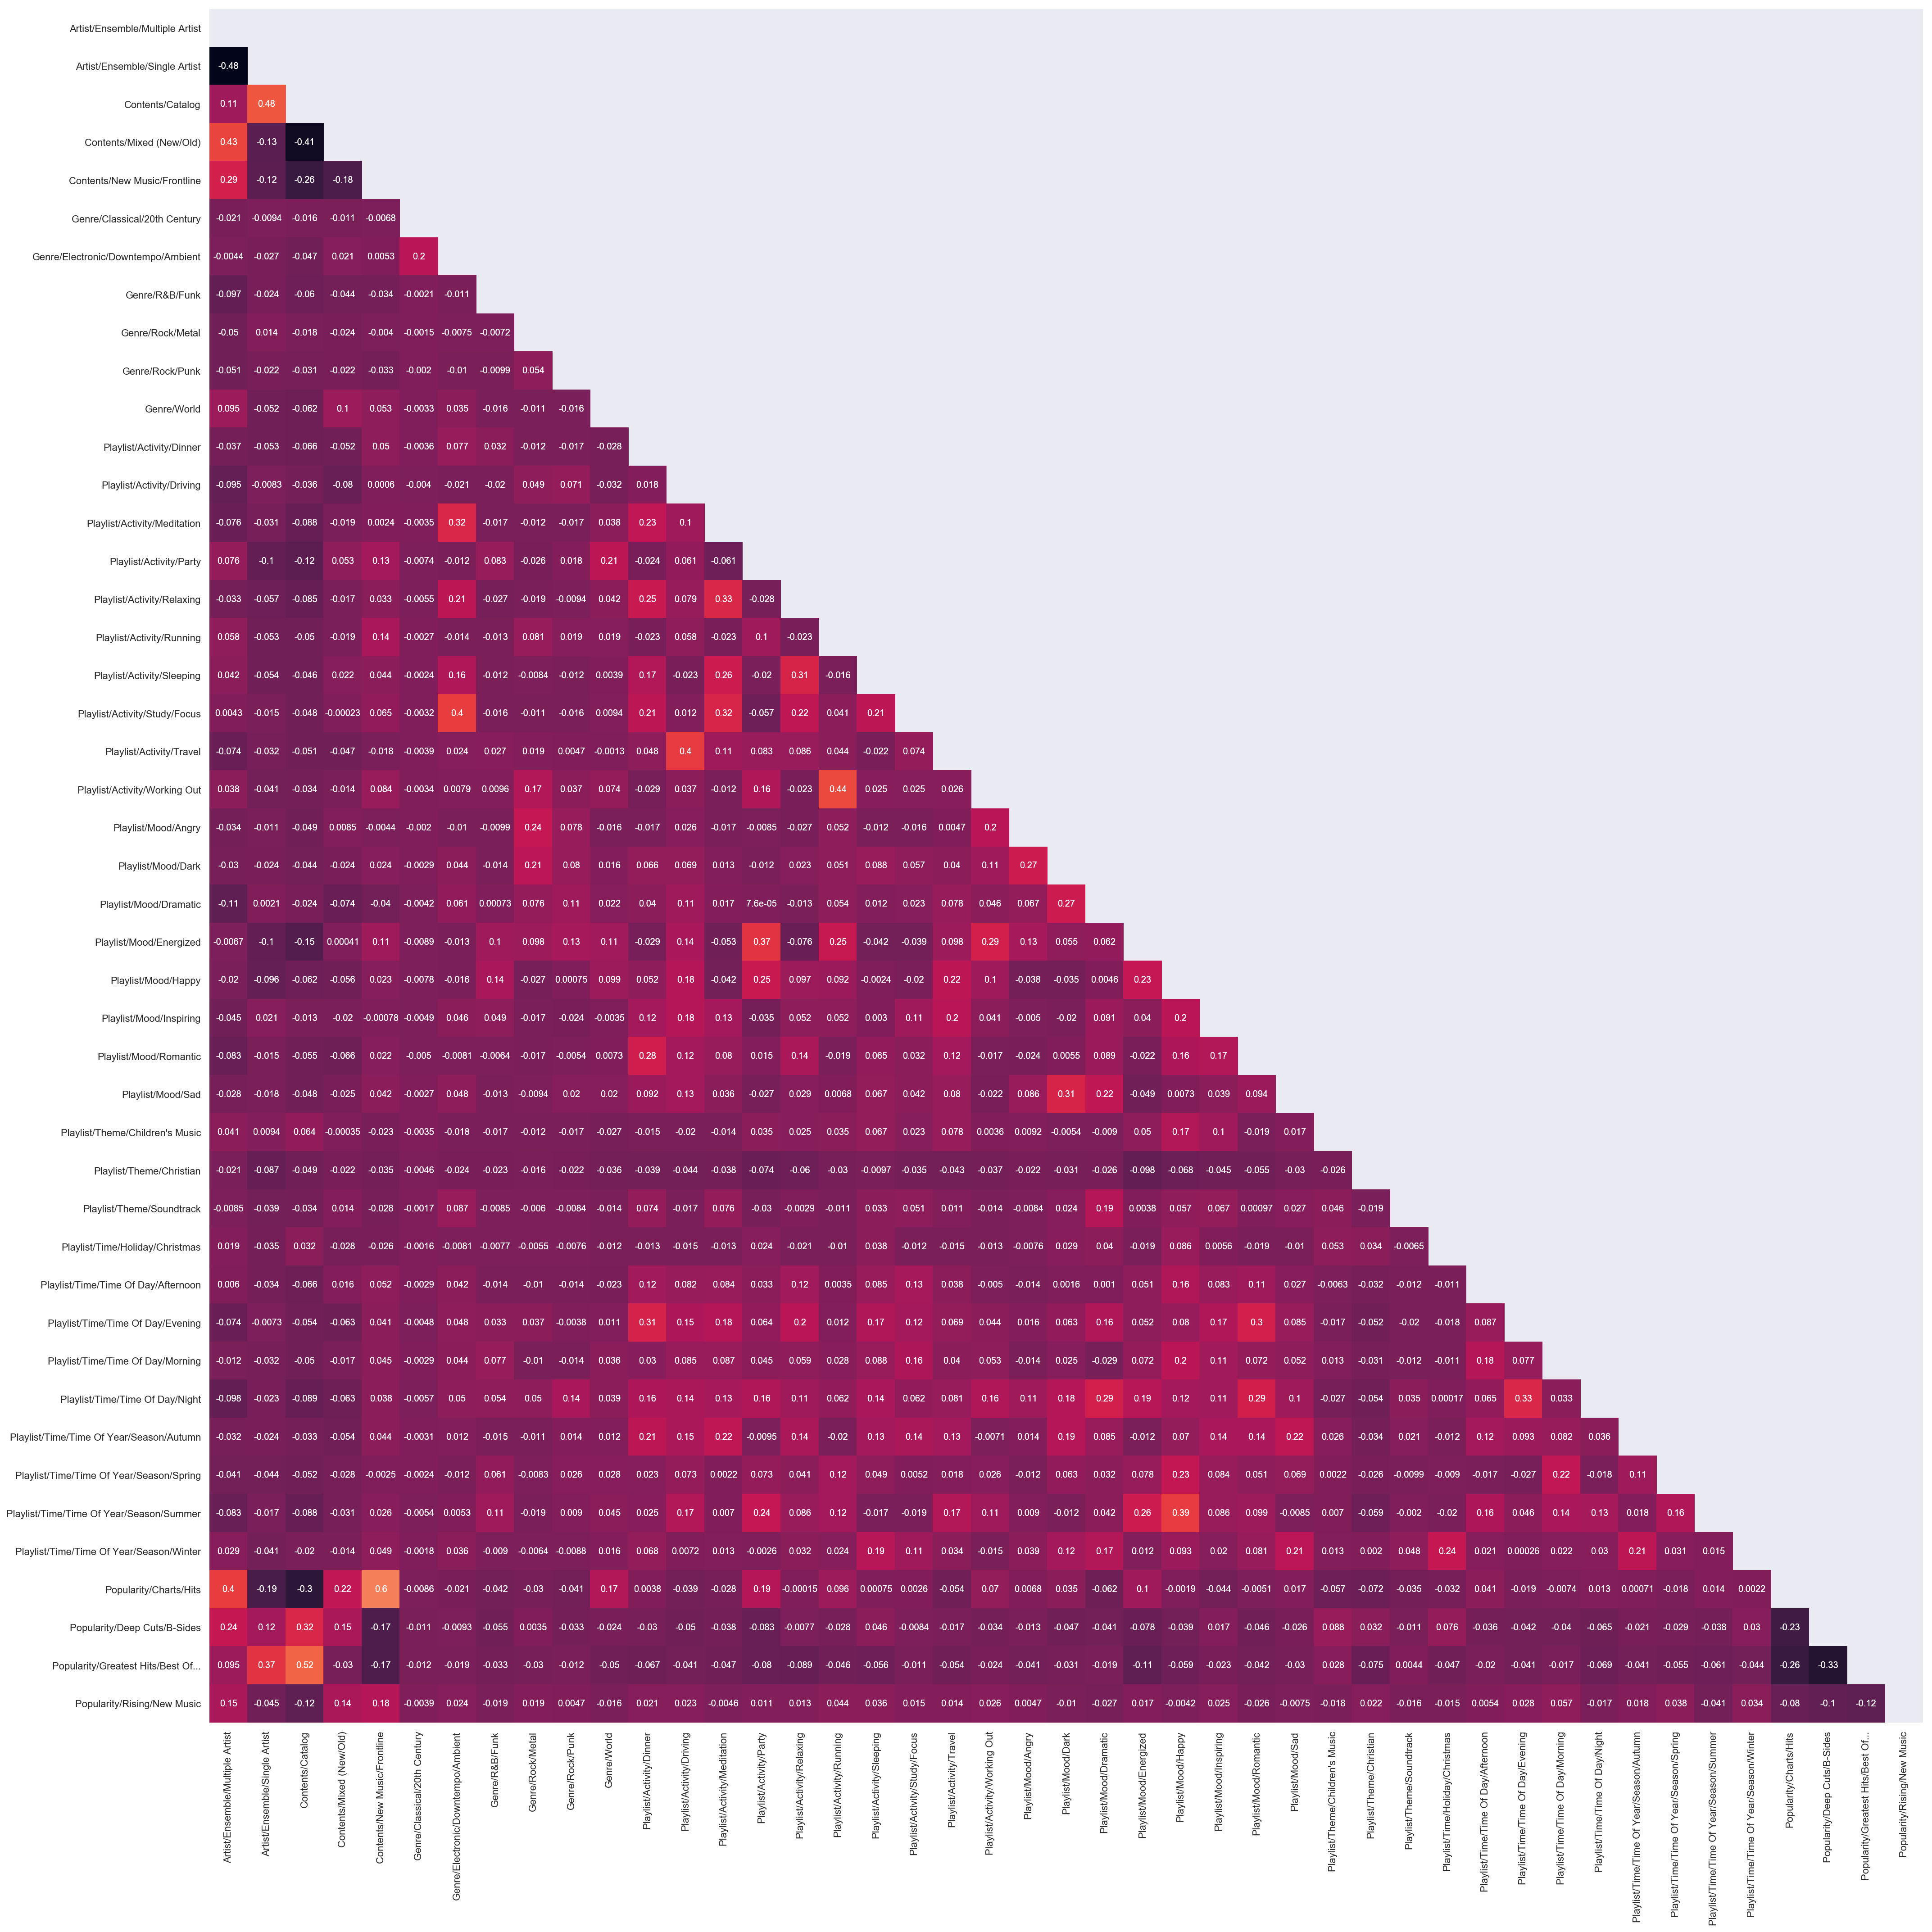

In [63]:
# Heatmap of tags

fig = plt.figure(figsize=(35,35))
ax = fig.gca()

corr=df_clust_id.corr(method='spearman')
corr_cols = corr.columns.sort_values()
corr2 = corr[corr_cols].sort_index()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr2, mask=mask, square=True,annot=True,cbar=False)
heatmap = sns.heatmap(corr2, mask=mask, square=True,annot=True,cbar=False)

heatmap.figure.savefig("output.png")
plt.show()

In [72]:
cols_alt = [re.findall('[a-zA-Z\s0-9-_&]+(?!.*\/)', str(x))[0] for x in df_clust_id.columns]

In [73]:
print(len(cols_alt))
print(len(set(cols_alt)))

38
38


## PCA Analysis

In [64]:
# Standardising the tag distribution before applying PCA analysis

ss = StandardScaler()
tags_st = ss.fit_transform(df_clust_id.iloc[:,1:])
df_tags_st=pd.DataFrame(tags_st,columns=df_clust_id.columns[1:], index=df_clust_id.iloc[:,0])

In [65]:
df_tags_st.shape

(2385, 45)

In [66]:
df_tags_st.head()

,Contents/New Music/Frontline,Popularity/Greatest Hits/Best Of...,Playlist/Time/Time Of Day/Morning,Genre/Electronic/Downtempo/Ambient,Playlist/Time/Time Of Day/Afternoon,Playlist/Activity/Dinner,Playlist/Time/Time Of Day/Night,Playlist/Mood/Dramatic,Playlist/Activity/Study/Focus,Playlist/Time/Time Of Year/Season/Winter,...,Playlist/Time/Holiday/Christmas,Playlist/Activity/Travel,Playlist/Activity/Sleeping,Contents/Mixed (New/Old),Playlist/Mood/Dark,Playlist/Theme/Children's Music,Playlist/Mood/Energized,Playlist/Theme/Christian,Genre/Classical/20th Century,Playlist/Time/Time Of Year/Season/Summer
playlist_id,,,,,,,,,,,,,,,,,,,,,
00Ot5pBIr1CuAlAJUivoOK,2.996511,-0.610137,-0.140237,-0.104984,-0.143315,-0.17389,-0.276159,-0.204792,-0.157876,-0.089613,...,-0.076842,-0.189883,-0.118451,-0.538411,-0.140237,-0.170012,2.289859,-0.224049,-0.020481,3.806181
00baB9PVWDBii7jtGvrPCs,-0.333721,-0.610137,-0.140237,-0.104984,-0.143315,-0.17389,-0.276159,-0.204792,-0.157876,-0.089613,...,-0.076842,-0.189883,-0.118451,1.857317,-0.140237,-0.170012,-0.436708,-0.224049,-0.020481,-0.262731
00e2vXzWaSmxJ1Fga6l2ug,2.996511,-0.610137,-0.140237,-0.104984,-0.143315,-0.17389,-0.276159,-0.204792,-0.157876,-0.089613,...,-0.076842,-0.189883,-0.118451,-0.538411,-0.140237,-0.170012,2.289859,-0.224049,-0.020481,-0.262731
00ovokuQiZ1iBM5hxFqyxP,-0.333721,-0.610137,-0.140237,-0.104984,-0.143315,-0.17389,-0.276159,-0.204792,-0.157876,-0.089613,...,-0.076842,-0.189883,-0.118451,-0.538411,-0.140237,-0.170012,2.289859,-0.224049,-0.020481,3.806181
00pQXl7juKerBcxIM8l6kn,-0.333721,1.638977,-0.140237,-0.104984,-0.143315,-0.17389,-0.276159,-0.204792,-0.157876,-0.089613,...,-0.076842,-0.189883,-0.118451,1.857317,-0.140237,-0.170012,-0.436708,-0.224049,-0.020481,-0.262731


In [67]:
# Getting PCA with all components

tags_pca = PCA().fit(df_tags_st)
tags_pcs = tags_pca.transform(df_tags_st)
tags_pcs = pd.DataFrame(tags_pcs, 
                        columns=['PC'+str(i) for i in range(1, tags_pcs.shape[1]+1)])

tags_pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,3.814605,4.203492,-2.023533,0.202318,-1.798038,2.756029,-1.006853,-1.653280,0.649053,-1.614510,...,2.287233,-1.648738,-2.513701,-0.725686,-0.049303,-3.880448,0.592657,0.135425,0.008330,-0.004477
1,-0.748819,1.067848,1.030990,0.061095,0.310302,-0.610764,0.705747,-0.215653,-0.404612,0.780106,...,0.135037,0.111137,-0.029840,-0.014233,0.029542,0.038159,0.105318,0.242462,1.123701,-0.020429
2,1.087461,3.772180,0.090787,0.039276,-1.312699,0.525850,-1.593917,0.131648,0.752902,-0.216517,...,-0.743026,-0.470028,-0.018512,0.172611,-0.178093,-0.161044,-0.459495,0.362114,-0.024794,-0.006237
3,2.167493,1.830133,-4.063923,3.887618,-0.228842,2.714793,3.242137,0.449908,-1.068351,-1.888881,...,1.839766,-0.296153,-3.322606,0.530520,-0.560389,-1.328393,0.010973,-0.099200,0.014132,0.001251
4,-1.124578,0.617132,0.753066,-0.002410,0.150800,0.081865,-0.056572,-0.138115,-0.464578,1.498399,...,0.047278,0.106168,-0.015111,-0.025643,-0.142795,0.038231,0.077525,0.926290,-0.033489,-0.000623


In [68]:
# Getting PCA with 2 components for the graph

tags_pca2 = PCA(n_components=2)
tags_pc2 = tags_pca2.fit_transform(df_tags_st)

tags_pc2

array([[ 3.81479084,  4.20524552],
       [-0.74915985,  1.06708925],
       [ 1.08798646,  3.77203208],
       ...,
       [-0.98174928,  0.92193808],
       [ 3.36437077, -2.48528227],
       [-1.75313673, -0.16491559]])

In [69]:
# Function for the Horn's parallel analysis

def horn_parallel_analysis(shape, iters=1000, percentile=95):
    pca = PCA(n_components=shape[1])
    eigenvals = []
    
    for i in range(iters):
        rdata = np.random.normal(0,1,size=shape)
        pca.fit(rdata)
        eigenvals.append(pca.explained_variance_)
    
    eigenvals = np.array(eigenvals)
    return np.percentile(eigenvals, percentile, axis=0)

tags_pa = horn_parallel_analysis(df_tags_st.shape, percentile=95)
tags_pa

array([1.3045453 , 1.2725331 , 1.24901754, 1.22942678, 1.21320066,
       1.19762565, 1.18262667, 1.16864178, 1.15450055, 1.14396095,
       1.13156316, 1.1191924 , 1.10773729, 1.09758743, 1.08666362,
       1.0764624 , 1.0651911 , 1.05376882, 1.04427386, 1.03424357,
       1.02470312, 1.01476087, 1.00559781, 0.99480655, 0.98607204,
       0.97666153, 0.96687181, 0.95705484, 0.94827765, 0.93834688,
       0.92824475, 0.91994875, 0.90982229, 0.90027423, 0.89038842,
       0.88094161, 0.87060359, 0.86011287, 0.84970901, 0.83926149,
       0.82828532, 0.81695643, 0.80433929, 0.79055051, 0.77412046])

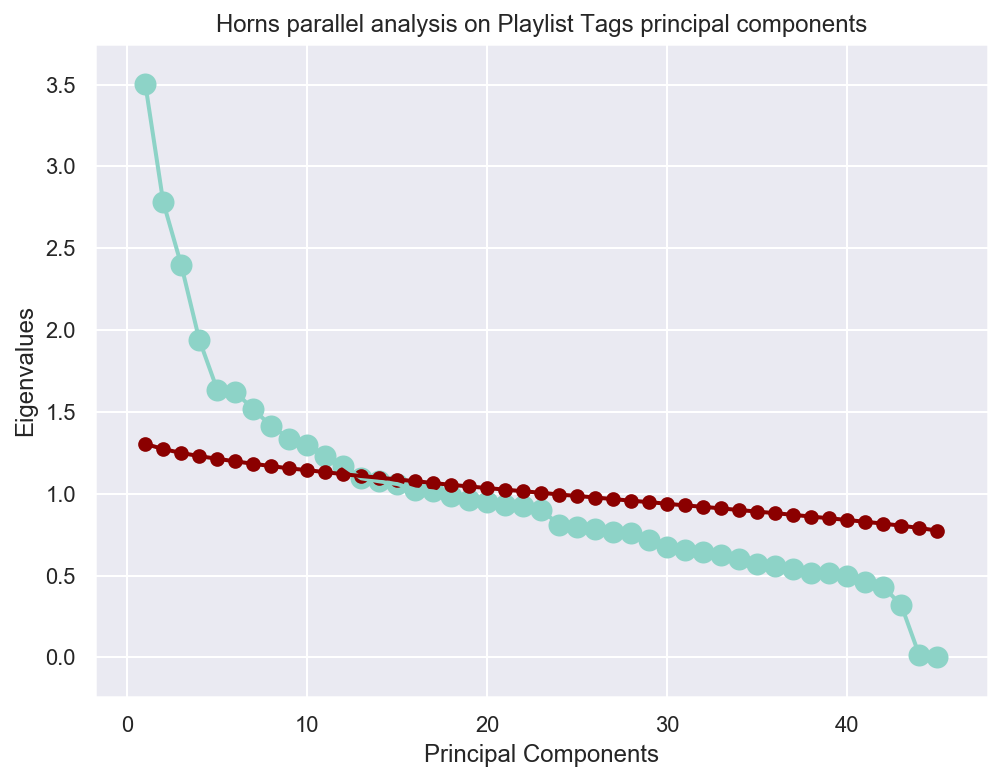

In [70]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, df_tags_st.shape[1]+1), tags_pca.explained_variance_, lw=2)
ax.scatter(range(1, df_tags_st.shape[1]+1), tags_pca.explained_variance_, s=100)

ax.plot(range(1, len(tags_pa)+1), tags_pa, lw=2, color='darkred')
ax.scatter(range(1, len(tags_pa)+1), tags_pa, s=40, color='darkred')


ax.set_title("Horns parallel analysis on Playlist Tags principal components")
ax.set_xlabel("Principal Components")
ax.set_ylabel("Eigenvalues")
plt.show()

In [71]:
tags_pa[:15]

array([1.3045453 , 1.2725331 , 1.24901754, 1.22942678, 1.21320066,
       1.19762565, 1.18262667, 1.16864178, 1.15450055, 1.14396095,
       1.13156316, 1.1191924 , 1.10773729, 1.09758743, 1.08666362])

In [72]:
tags_pca.explained_variance_[:15]

array([3.50561353, 2.7810432 , 2.39753512, 1.94117985, 1.63537154,
       1.6211654 , 1.51611747, 1.41307976, 1.33657596, 1.29730704,
       1.23131949, 1.17169188, 1.09401163, 1.07545455, 1.05876642])

In [73]:
tags_pca.explained_variance_ratio_[:12]

array([0.07786986, 0.06177505, 0.05325622, 0.04311924, 0.03632635,
       0.03601079, 0.03367737, 0.03138861, 0.02968923, 0.02881696,
       0.02735118, 0.02602668])

In [75]:
np.sum(tags_pca.explained_variance_ratio_[:12])

0.48530754797195685

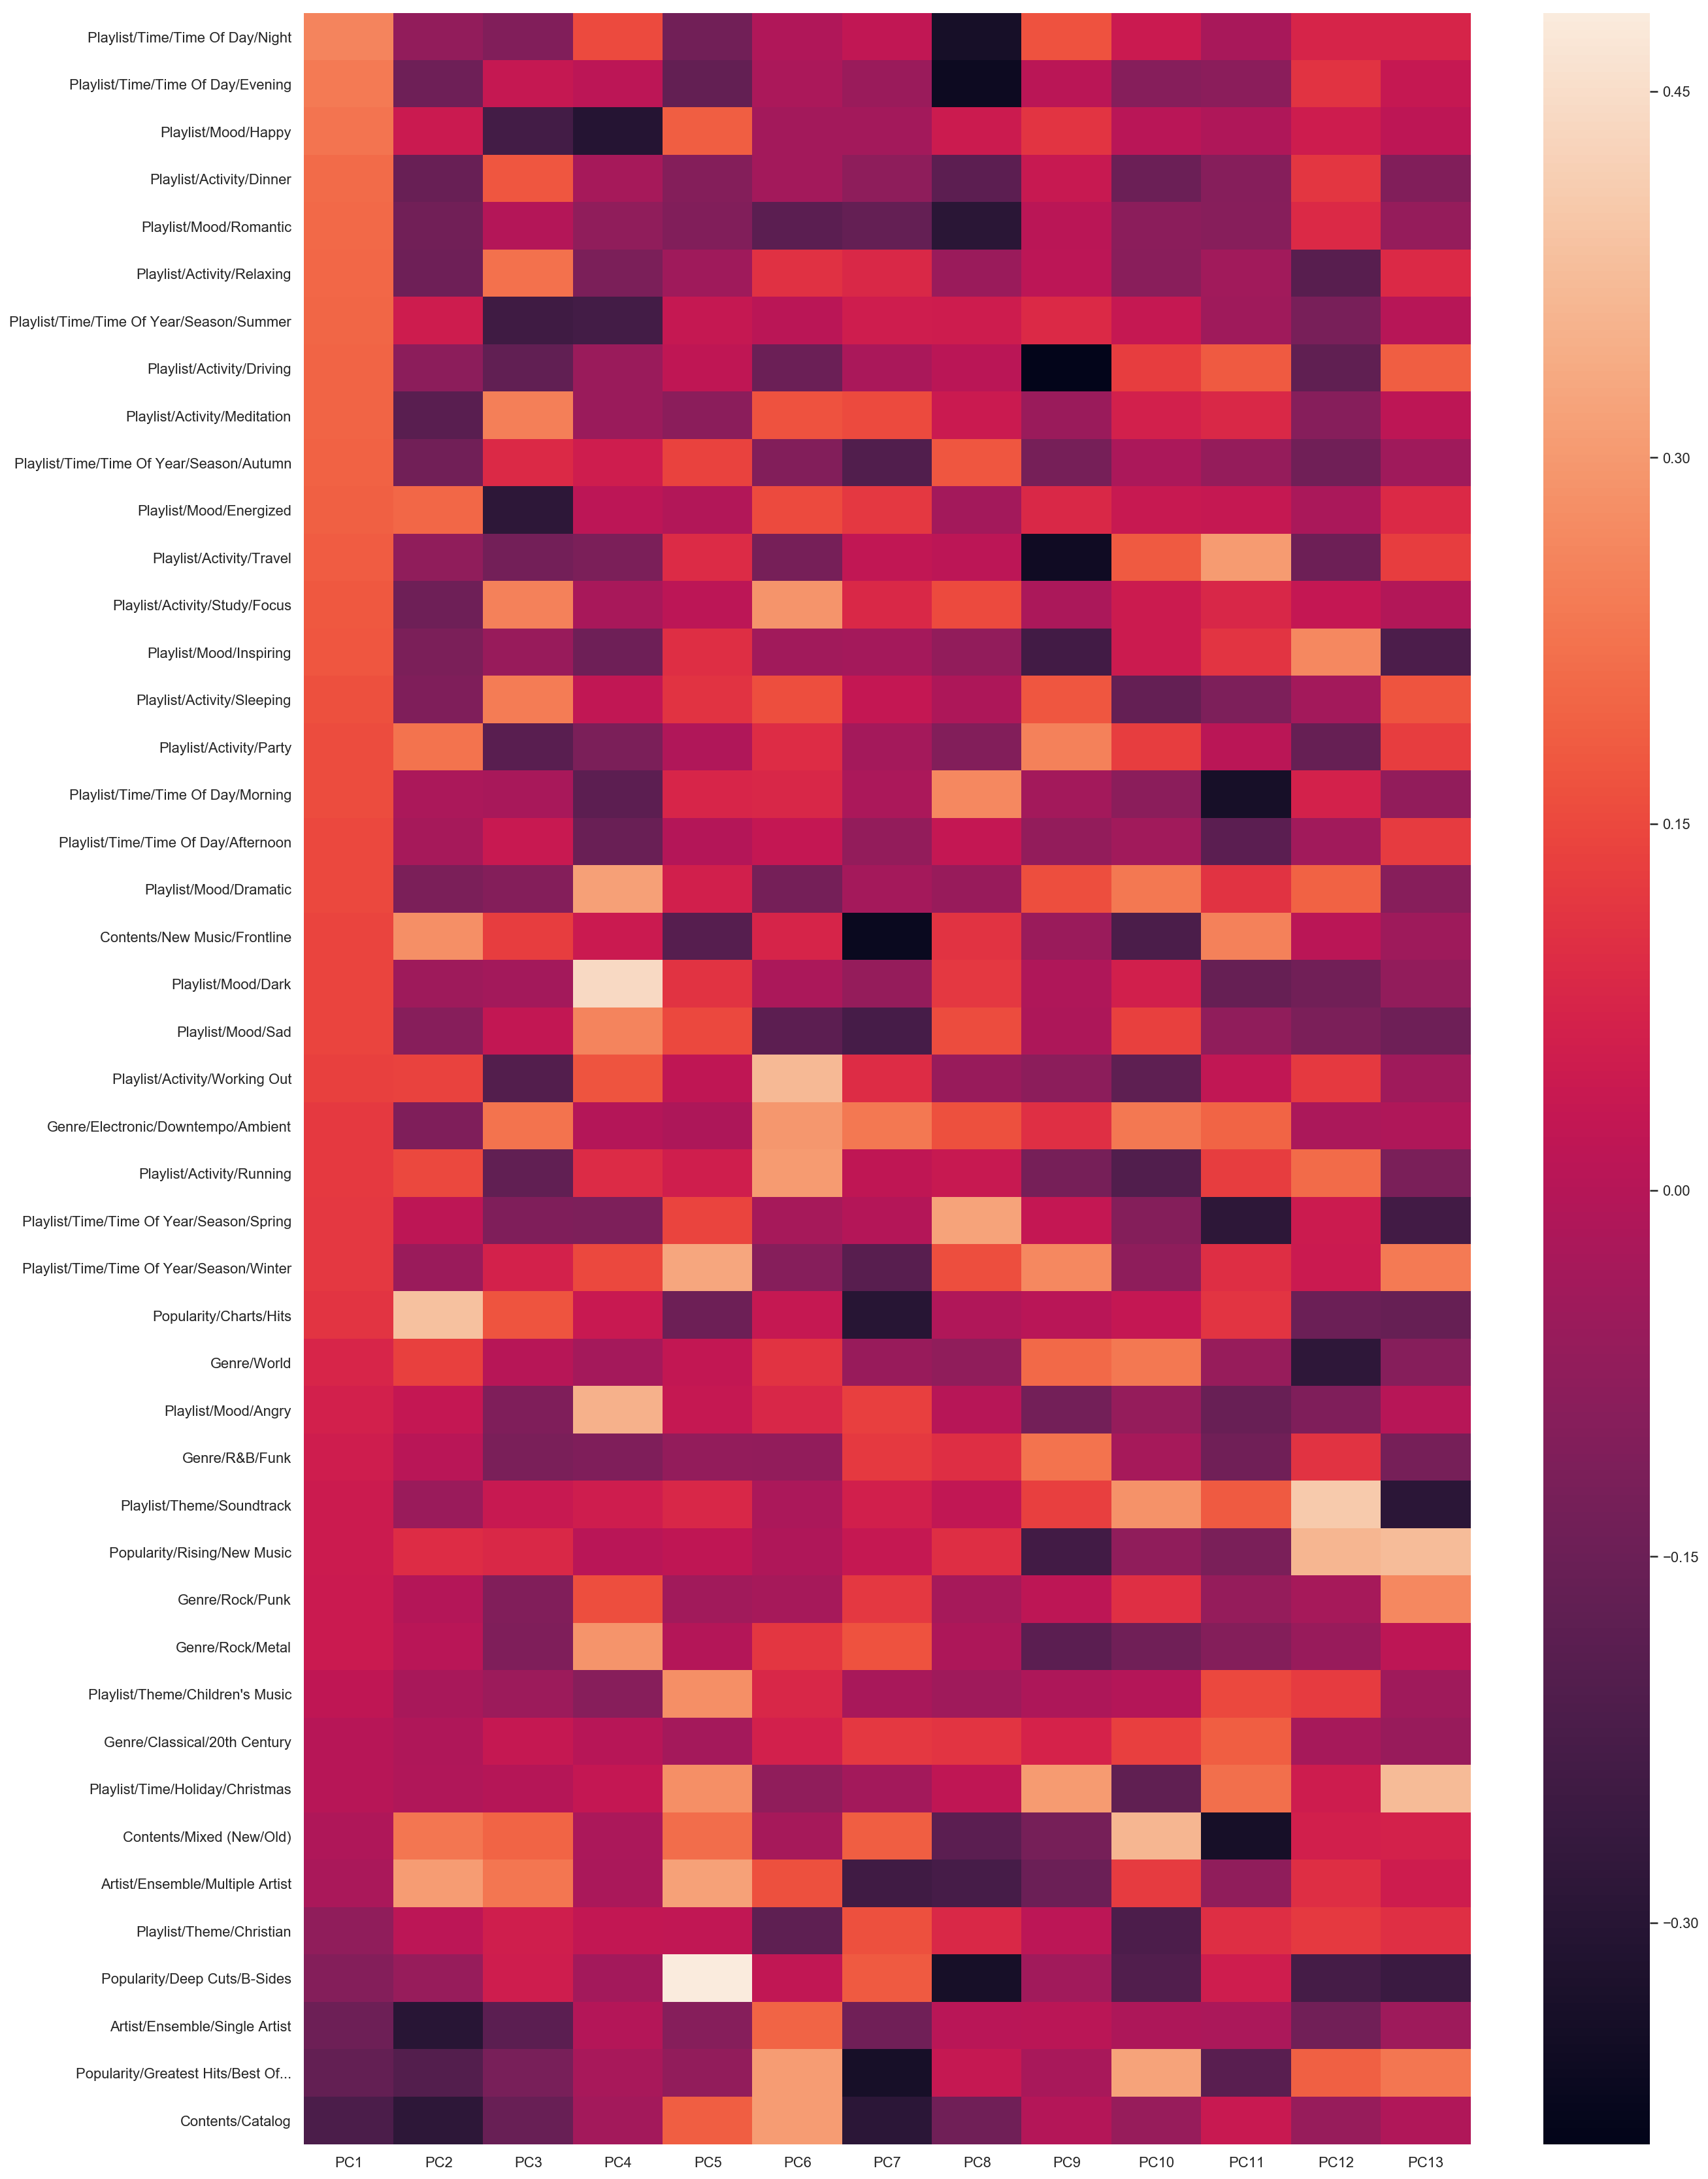

In [76]:
fig, ax = plt.subplots(figsize=(20,30))

sns.heatmap(pd.DataFrame(tags_pca.components_[0:13].T, 
                         index=df_tags_st.columns,
                         columns=['PC'+str(i) for i in range(1, 14)]).sort_values(by='PC1',ascending=False))

plt.show()

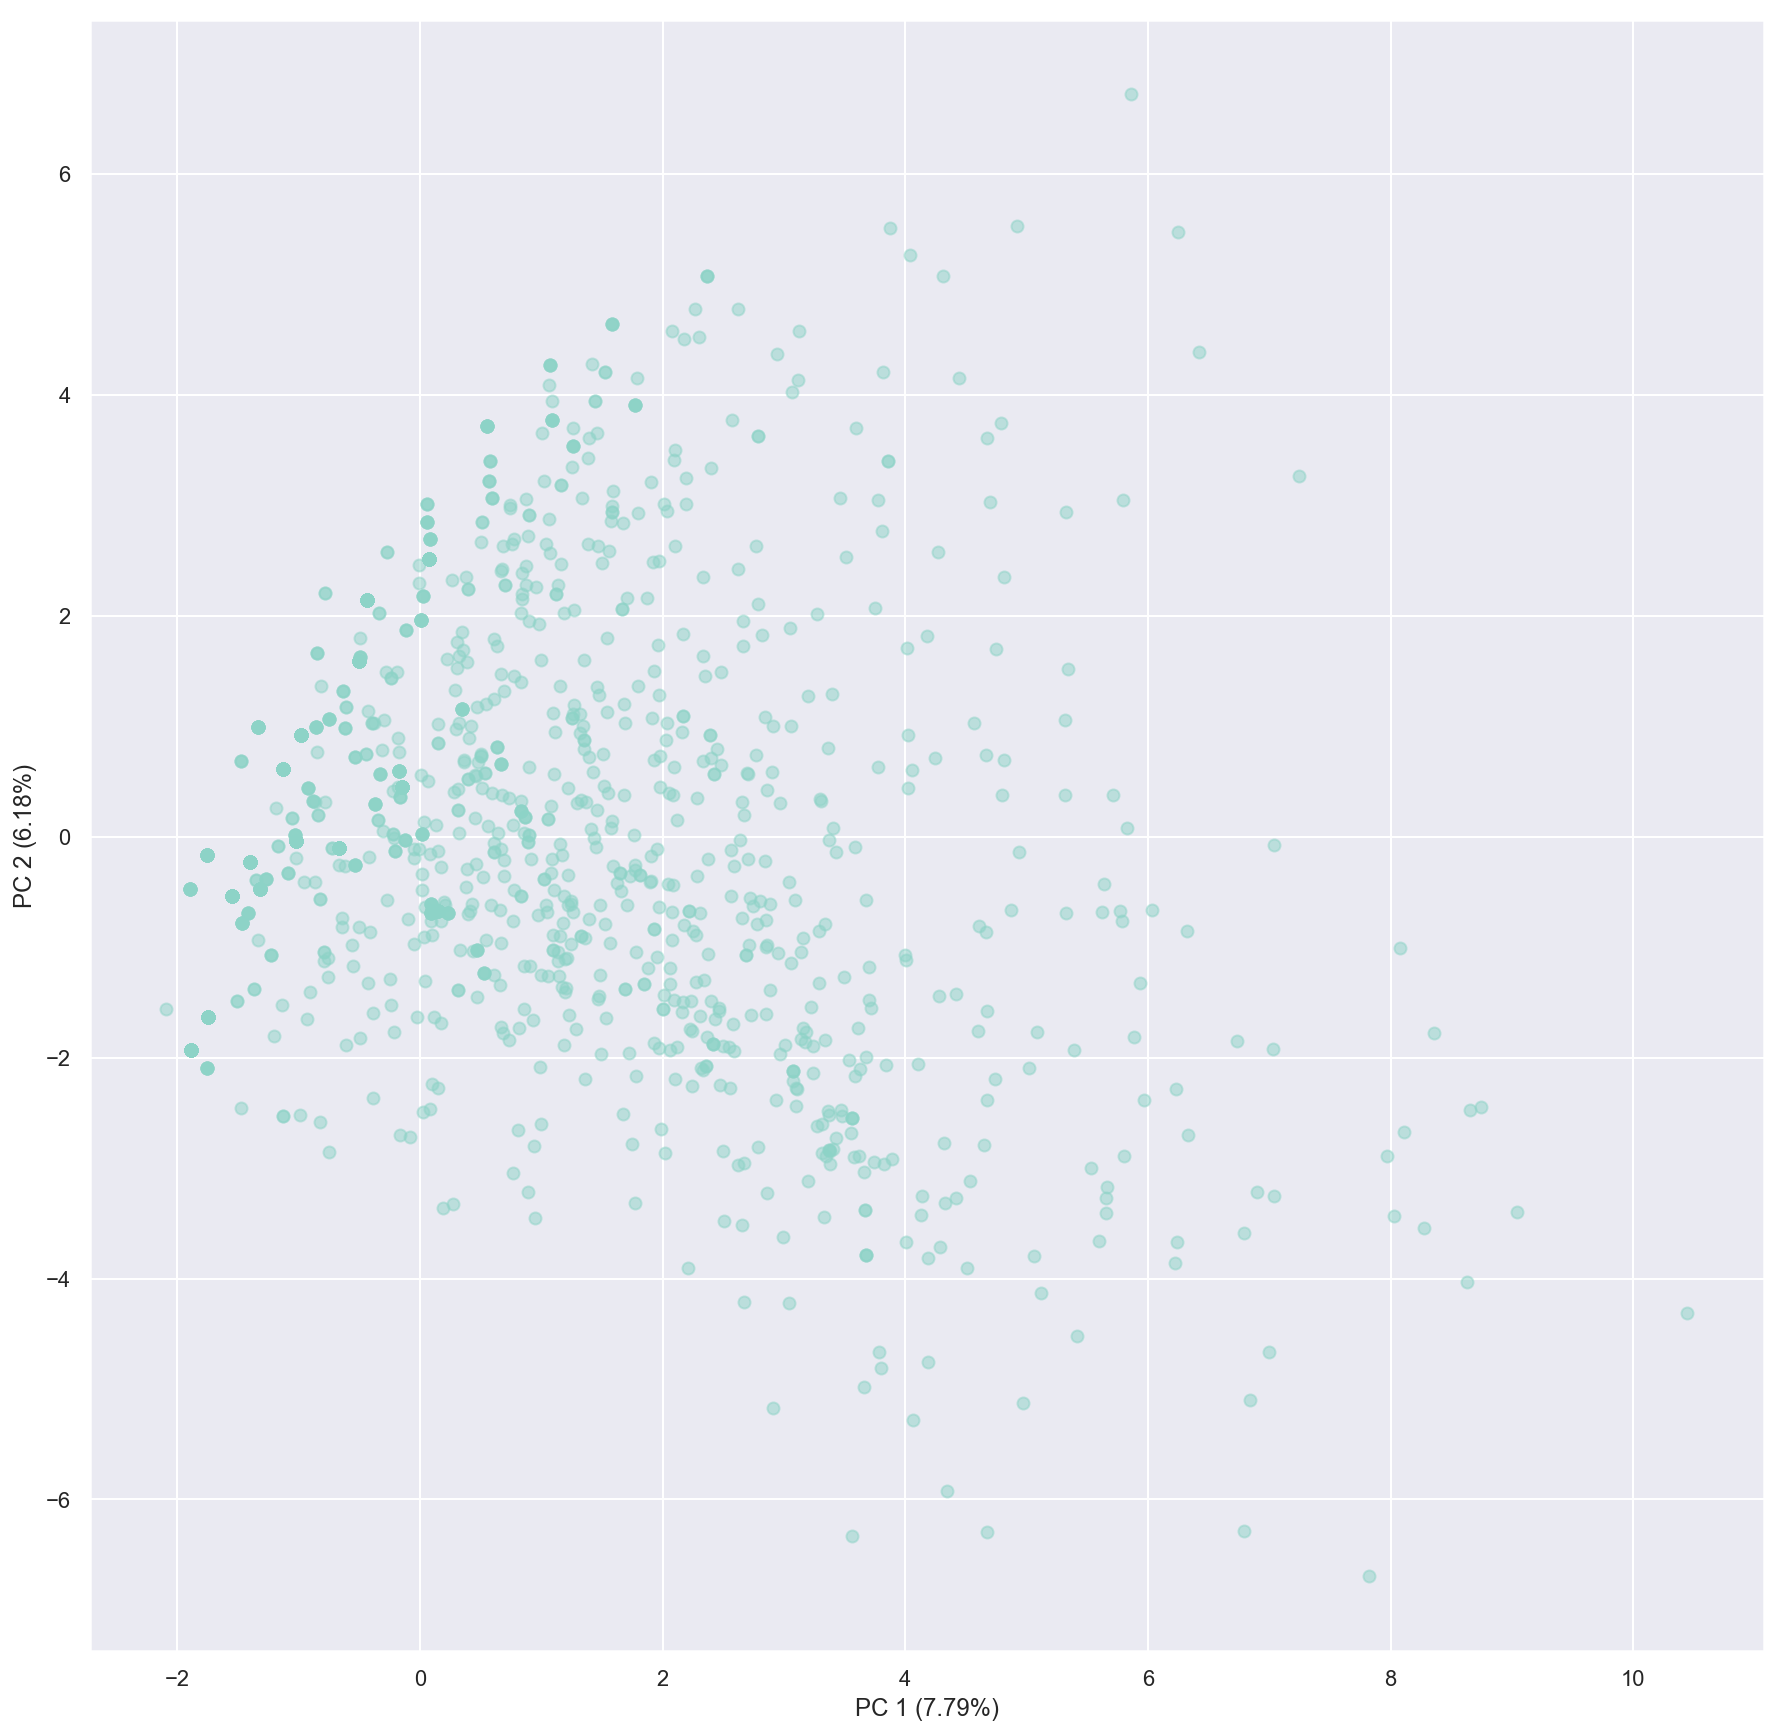

In [77]:
# Create the scatter plot
plt.figure(figsize=(15,15))
plt.scatter(tags_pc2[:,0], tags_pc2[:,1], alpha=0.5)

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (tags_pca2.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (tags_pca2.explained_variance_ratio_[1]*100)) 

# Done
plt.show()

## Clustering

In [78]:
# Function to run clutering algorithms and review their output

def dbscan_tuning(df,eps_list,min_samples_list):
    
    df_res = pd.DataFrame(columns=['eps','min_sample','n_clusters','unlabelled_prop','silhouette_coeff'],
                         index = range(len(eps_list)*len(min_samples_list)))
    c=-1
    
    for i,eps_i in enumerate(eps_list):
        for j, min_j in enumerate(min_samples_list):
            
            c=c+1
            
            dbscn = DBSCAN(eps=eps_i, min_samples=min_j)
            dbscan=dbscn.fit(df)
            labels = dbscan.labels_ 
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            #print("epsilon, min_samples: ", eps_i, min_j)
            #print( "clusters: ", n_clusters_)
            #print("unlabelled proportion: ", float(list(labels).count(-1))/labels.shape[0])
            #print("silhouette coefficient: ", metrics.silhouette_score(df, labels))
            #print()
            
            df_res['eps'][c]=eps_i
            df_res['min_sample'][c]=min_j
            df_res['n_clusters'][c]=n_clusters_
            df_res['unlabelled_prop'][c]=float(list(labels).count(-1))/labels.shape[0]
            df_res['silhouette_coeff'][c]=metrics.silhouette_score(df, labels)
            
            
    return df_res

In [79]:
# Range of clustering parameters

eps_list=range(8,16)
min_samples_list=[2,3,4]

In [80]:
df_res = dbscan_tuning(df_tags_st,eps_list,min_samples_list)

In [81]:
df_res.head(10)

,eps,min_sample,n_clusters,unlabelled_prop,silhouette_coeff
0,8,2,21,0.0469602,0.406349
1,8,3,14,0.0528302,0.411547
2,8,4,10,0.0595388,0.411197
3,9,2,16,0.0289308,0.42484
4,9,3,10,0.0339623,0.429368
5,9,4,9,0.0356394,0.428531
6,10,2,15,0.0192872,0.424477
7,10,3,9,0.0243187,0.424536
8,10,4,8,0.0255765,0.423615
9,11,2,10,0.0125786,0.440985


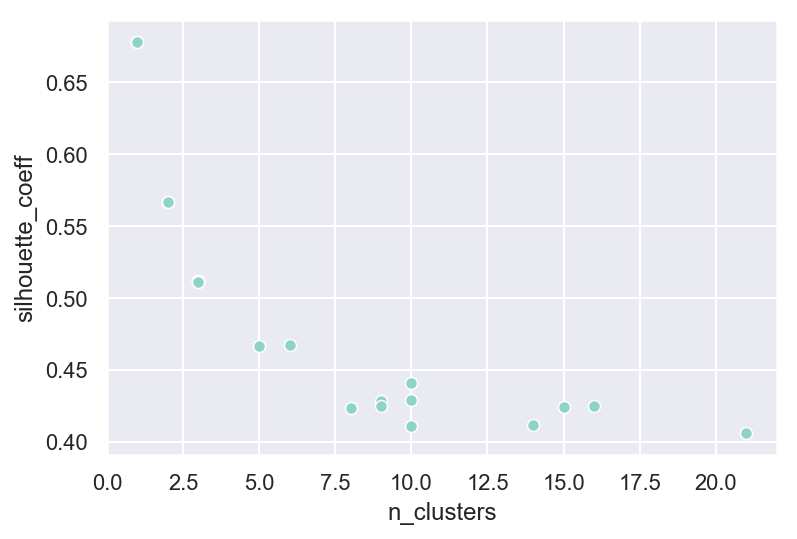

In [82]:
ax = sns.scatterplot(x="n_clusters", y="silhouette_coeff", data=df_res)

The winner is the DBSCAN with eps 11 and min_samples 2:

In [86]:
dbscn_10_2 = DBSCAN(eps=11, min_samples=2)
dbscan=dbscn_10_2.fit(df_tags_st)
labels = dbscan.labels_ 

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_tags_st, labels))

Silhouette Coefficient: 0.441


In [87]:
pl_clust=pd.DataFrame(zip(labels,df_tags_st.index),columns=['label','playlist_id'])
pl_clust.to_csv('playlist_clust.csv')

pl_clust.groupby('label').count().sort_values(by='playlist_id',ascending=False)

,playlist_id
label,
0,2312
-1,30
3,12
5,10
2,6
4,4
6,3
1,2
7,2


In [88]:
clust_dict={}

for i,lbl in enumerate(pl_clust['label']):
    if lbl in clust_dict.keys():
        clust_dict[lbl].append(pl_clust['playlist_id'][i])
    else:
        clust_dict[lbl]=[pl_clust['playlist_id'][i]]
        
clust_dict

{0: ['00Ot5pBIr1CuAlAJUivoOK',
  '00baB9PVWDBii7jtGvrPCs',
  '00e2vXzWaSmxJ1Fga6l2ug',
  '00ovokuQiZ1iBM5hxFqyxP',
  '00pQXl7juKerBcxIM8l6kn',
  '00py66Mc5WwCZlvhyWKqPA',
  '00xkZo0UVb5tsXPj2I9DZz',
  '014Mr2IJhIfZFu6NLYl6nO',
  '0156tLfZJwb6CDgXRTfzT5',
  '015H26Hfu78TZG6lAc4tSS',
  '01DbkmjFPYPeZyw7MxBal5',
  '01LrEloa2zGHxA0I8KNnWT',
  '01cMmxcvXslRy2gw5ZYzcj',
  '01yzVaVYZmcN5zC8KD49AS',
  '02ES3fS2eHdLnDEuEUD60V',
  '02EgXbc34R94ezZe3sjqoy',
  '03v08073YFtriJYto8uO1K',
  '049Htl8YyOrScgwMUgXzFq',
  '04BPAHNEj2hnAEftQftm3k',
  '04QGQDLqqhWnTyY7peE4o2',
  '04hOL4cJstu4DyJJLuinMT',
  '054GHYOgMxL2XoEDFw9X5b',
  '055xSrqh5OJmlZryiCaj0y',
  '05BPX0BFVvdrNLlSHiTTPA',
  '05lr5JlZRRgMb5wy4ptO3j',
  '05n4Z4Up6zknsIsoklyUmN',
  '063OOAs1pcT92wa1WOTIES',
  '06I4eUFA4TpvFExL5CuH86',
  '06K9bQi63QEqyrPFeEMm3d',
  '06Kff3jXCpcy3SIZsRAaN5',
  '06Ln1gOM6y9Hbh2LCWETpO',
  '06LsCWA0CN40Z9wmoMou77',
  '06fJ4v9NQJE7sslLMwpCOw',
  '06kq6UEHx5P4NhsmG4rmjZ',
  '06m5HzAGIkYyLsDdNpWoCp',
  '07TYO8N5n2xj47

In [89]:
pl_clust.to_gbq(project_id='umg-comm-tech-dev', if_exists='replace', 
                destination_table='playlist_sequencing.dbscan_clusters')

1it [00:04,  4.99s/it]


In [90]:
clust_and_meta_sql = """
SELECT
  label,
  playlist_id,
  MAX(name) AS name,
  MAX(e.parent_brand) AS parent_brand,
  MAX(brand) AS brand,
  MAX(playlist_description) AS description,
  MAX(playlist_owner) AS user,
  MAX(follower_count) AS n_followers
FROM
  `umg-comm-tech-dev.playlist_sequencing.dbscan_clusters` c
LEFT JOIN
  `umg-comm-tech-dev.playlist_sequencing.create_export` e
ON 
  c.playlist_id=e.spotify_id  
LEFT JOIN
  `umg-edw.spotify.playlist_history`
USING
  (playlist_id)
GROUP BY
  label,
  playlist_id
"""

In [91]:
clust_and_meta = gbq.read_gbq(clust_and_meta_sql, project_id='umg-comm-tech-dev', dialect='standard')
clust_and_meta.shape

(2385, 8)

In [92]:
clust_and_meta.head()

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
0,0,1All5I9pyXjJ2ArZt4zuCX,NF Real Music Playlist,Artist Playlists,Artist Playlists,What I'm listening to right now and some songs...,nfofficial,152572.0
1,0,4UjnuA7qBv6aXRt1zk4Qdv,Spice Girls Best Of,None,uDiscover,"The most-streamed Spice Girls tracks, all in o...",spicegirlsofficial,35895.0
2,0,014Mr2IJhIfZFu6NLYl6nO,Top Of The Spot,Digster,Digster IT,None,None,NaN
3,0,4L1uHh1Nh8iJsR1ZNYO4Wg,Violin Masters,None,Deutsche Grammophon,"Since the early 1900s, Deutsche Grammophon has...",deutschegrammophon,1043.0
4,0,1NMJEMfjW3hfj1fi69i4zx,"Douceur Urbaine (Dadju, Booba, Vegedream...)",Digster,Digster FR,Découvrez l'autre facette de la pop urbaine ! ...,digster.fr,10863.0


## Investigating clusters


####  Cluster number 3 seems to be Soundtracks

In [93]:
clust_and_meta[clust_and_meta.label==3]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
94,3,1NM9DxNxI6ev1W1bzSZ1j2,Best Picture - Oscar Nominations,None,uDiscover,None,None,NaN
520,3,69HJDGoLGjaN6F80OnyIYP,Broadway Hits,Digster,Digster FM,Featuring the cast of Broadway’s Tony Award no...,digster.fm,16232.0
626,3,4j1neWzcUfjVxwV3A4GyeA,Trilha Sonora de Filmes | Rocketman | Filme do...,Digster,Digster BR,"Você escuta aqui a trilha do filme Rocketman, ...",digster_brasil,43440.0
731,3,5xWedvUlpd80UBjjB08pFH,Music On Words: The Best Songs Based On Books,None,uDiscover,None,None,NaN
741,3,2MY0cjyOxCDnfcUmFgmA5l,007 - La Musique De James Bond,Digster,Digster FR,None,None,NaN
1116,3,1GJdraGkXItHc8BCsWOrea,Disney Para Sempre | Dumbo | Mary Poppins | Wi...,Digster,Digster BR,Todos os sucessos da Disney reunidos em uma pl...,digster_brasil,3406.0
1379,3,2eG7CcdMMcAOPPme80JaT7,Musicals Hits,None,HITS,On Screen &amp; On Stage. From films to Broadw...,digster.co.uk,195049.0
1477,3,1kVntaVpxmlSs8Nlh8oCzt,Movies HITS,None,HITS,Original motion picture soundtracks to your fa...,digster.co.uk,36137.0
1511,3,5JoDbclY8x7d0SkKq3FR1L,Trilha Sonora da Vida,Digster,Digster BR,Sua dose diária de nostalgia reunida em uma pl...,digster_brasil,14355.0
1520,3,0WKH79g3w7hCU1tO9ts0kW,Jazz Loves Disney,Digster,Digster FR,None,None,NaN


####  Cluster number 5 is Christmas

In [94]:
clust_and_meta[clust_and_meta.label==5]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
327,5,6mIRMg8kpuok7eS3o7uUx7,Christmas Country,Digster,Digster FM,The best Country Christmas songs!,digster.fm,15238.0
425,5,4ObeA5hqPSnCyPMaszMlOD,None,None,None,There goes Halloween. Here comes Christmas! Li...,digster.fm,11613.0
690,5,1FR1VsWKhbMHXZcJshf9OQ,JULEHITS - Julesange du elsker - Julemusik ti...,Digster,Digster DK,På Digster JULEHITS fejrer vi jul på fineste m...,digster.dk,34964.0
793,5,5lTy3w4iZbOAdJPWV7fEN5,Have Yourself a Blues Christmas,None,uDiscover,"<a href=""http://www.udiscovermusic.com"">uDisco...",udiscover,1234.0
1074,5,1A4meEJ1VUbnHhIxzfC17M,Digster CHRISTMAS SWING,None,Digster CH,The fluffiest Jazzy Christmas tracks for a coz...,digsterdeutschland,2204.0
1474,5,7iMyUkmPe7epyb8J1mqT9y,Christmas Music,Digster,Digster FM,Turn up the joy in time for Christmas. However...,universal.fm,339510.0
1676,5,30zIqHLjwPVDyXwxduVZCB,Christmas Rock,Digster,Digster FM,Simply all the Hunger Games Soundtracks in one...,digster.fm,38180.0
1862,5,7GY66rE4X1P0zsE1Fv3AyD,'Louie Louie' In 20 Takes,None,uDiscover,None,None,NaN
2076,5,1ZGMzp7NdSSBUpe3dK3X41,Boyd Demo,None,PITCHED Test Playlists,None,None,NaN
2327,5,2gUU4fiNI1Fuu1FWcR7uQh,Have Yourself a Jazz Christmas,None,uDiscover,"<a href=""http://www.udiscovermusic.com"">uDisco...",udiscover,5586.0


####  Cluster number 3 is Hard Rock

In [95]:
clust_and_meta[clust_and_meta.label==2]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
124,2,2acOrxOZ4Aea8LFFbSmF5c,Marilyn Manson: The Complete Collection,Artist Playlists,Artist Playlists,,marilynmanson_official,57624.0
295,2,028qeaDokT41qHkYsLjj4L,None,None,None,None,None,NaN
947,2,0RO49mStzTTVIMY05mZLi0,KISS Best Of,Artist Playlists,Artist Playlists,The most played KISS tracks on Spotify right n...,kissofficial,17215.0
1427,2,7LGt8neoUvB8Lx102zifgY,Def Leppard Best Of,Artist Playlists,Artist Playlists B,Def Leppard is officially a nominee for the 20...,defleppardofficial,12572.0
2062,2,5OjMsLblKP5Uwt0MVvab8X,Thrash Metal History,None,uDiscover,None,None,NaN
2209,2,5sgb06XdH7xlziL0WFQDh0,Metal Supreme,Digster,Digster DE,"The must knows and hidden gems of Heavy Metal,...",digsterdeutschland,895.0


####  Cluster number 2 is Italian and Sad Music

In [96]:
clust_and_meta[clust_and_meta.label==4]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
280,4,61Y6IrXoJtfqkYDPCGgqia,Cantautori Italiani,Digster,Digster IT,"Paolo Conte, Francesco Guccini, Franco Battiat...",digster_italy,1110.0
727,4,5tpOGa8unbNqxC14TNJGju,Italia In Viaggio,Digster,Digster IT,Tutta la migliore musica italiana.Viva l'Itali...,digster_italy,22444.0
977,4,3m63xTSCvzPOUB042OO6I7,Winter Vibes,Digster,Digster IT,Hot Tracks for Cold Cold days. the real best o...,digster_italy,524.0
1436,4,0ieRWquYaE5uf3XvbPxsi5,Elliot Smith Digging Deeper,None,uDiscover,None,None,NaN


Smaller groups investigation

In [101]:
clust_and_meta[clust_and_meta.label==9]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
323,9,4OKGv1qIxrx1qNWNRrqMei,Heavy Metal Thunder,None,uDiscover,None,None,NaN
1585,9,7vyY1k0tY8cOgCYbsQIatf,Metal,Digster,Digster FM,"The best damn <a href=""http://www.digster.fm/r...",digster.fm,28878.0


## Trying Affinity Propagation clustering

In [83]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [84]:
X = df_tags_st.copy()

In [102]:
af = AffinityPropagation(convergence_iter=30, verbose=True).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Did not converge
Estimated number of clusters: 1186
Silhouette Coefficient: 0.279
